In [201]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


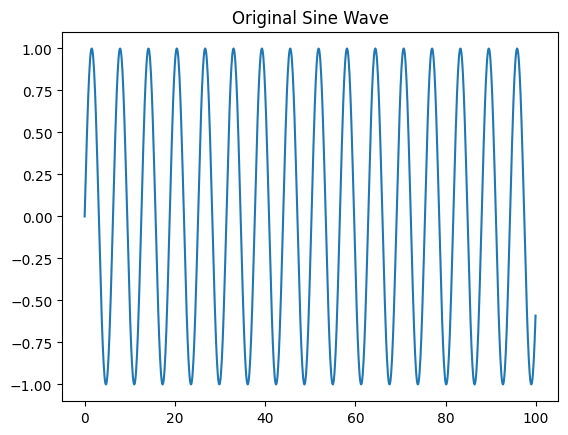

In [202]:
time = np.arange(0, 100, 0.1)
data = np.sin(time)

plt.plot(time, data)
plt.title("Original Sine Wave")
plt.show()


In [203]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) 
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  
# Train-validation split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [204]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)           # RNN output
        out = self.fc(out[:, -1, :])   # take last time step
        return out

model = RNNModel()


In [205]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [206]:
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch 10, Train Loss: 0.0152, Val Loss: 0.0417
Epoch 20, Train Loss: 0.0049, Val Loss: 0.0086
Epoch 30, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 40, Train Loss: 0.0002, Val Loss: 0.0005
Epoch 50, Train Loss: 0.0001, Val Loss: 0.0003


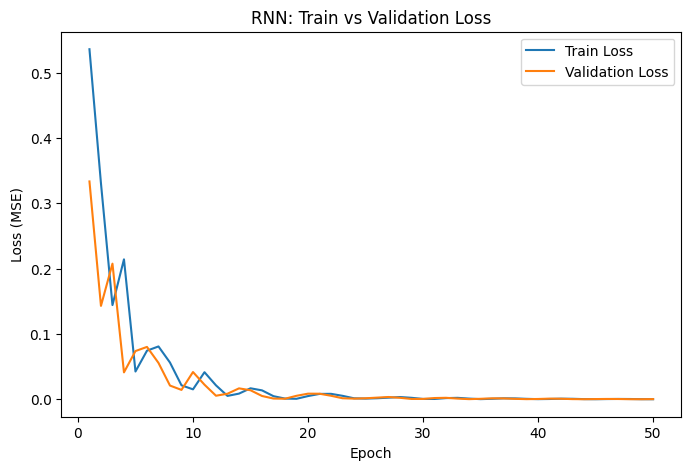

In [207]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('RNN: Train vs Validation Loss')
plt.legend()
plt.show()


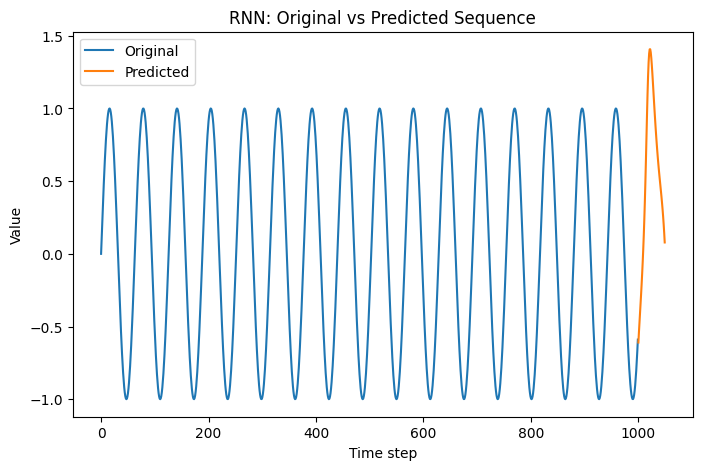

In [208]:
model.eval()
predictions = []
current_seq = X[-1].unsqueeze(0)

for _ in range(50):
    with torch.no_grad():
        pred = model(current_seq)
        predictions.append(pred.item())
        pred_reshaped = pred.unsqueeze(1)  # [1,1,1]
        current_seq = torch.cat((current_seq[:,1:,:], pred_reshaped), dim=1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(len(data)), data, label='Original')
plt.plot(range(len(data), len(data)+50), predictions, label='Predicted')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('RNN: Original vs Predicted Sequence')
plt.legend()
plt.show()


In [209]:
from sklearn.metrics import mean_squared_error

model.eval()
with torch.no_grad():
    y_pred = model(X_val)
mse = mean_squared_error(y_val.numpy(), y_pred.numpy())
print(f'Mean Squared Error (MSE): {mse:.6f}')


Mean Squared Error (MSE): 0.000290
